# Language classification


We will perform text classification starting from plain text files. We train a binary classifier to perform language programming classification on a subset of a Stack Overflow dataset.


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.15.0



### Language Tag Classification

This notebook trains a multi class analysis model to classify stack overflow questions's tags as Python, Java, C# or Javascript questions, based on the text of the question. This is an example of multi-class—classification, an important and widely applicable kind of machine learning problem.

The dataset we will use contains the body of several thousand programming questions (for
example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of
these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). The dataset is a subset of several thousand questions extracted from the much larger
public Stack Overflow dataset on BigQuery, which contains more than 17 million posts.

### Load and explore the Stack Overflow dataset

In [3]:
!mkdir stack_overflow_16k

In [4]:
!tar -xvf 'stack_overflow_16k.tar(2)(6).gz' -C 'stack_overflow_16k'

Streaming output truncated to the last 5000 lines.
test/csharp/1993.txt
test/csharp/1039.txt
test/csharp/1987.txt
test/csharp/220.txt
test/csharp/546.txt
test/csharp/552.txt
test/csharp/234.txt
test/csharp/1978.txt
test/csharp/1788.txt
test/csharp/1950.txt
test/csharp/208.txt
test/csharp/1944.txt
test/csharp/787.txt
test/csharp/1213.txt
test/csharp/1575.txt
test/csharp/1561.txt
test/csharp/1207.txt
test/csharp/793.txt
test/csharp/963.txt
test/csharp/1549.txt
test/csharp/977.txt
test/csharp/744.txt
test/csharp/750.txt
test/csharp/988.txt
test/csharp/778.txt
test/csharp/1367.txt
test/csharp/195.txt
test/csharp/1401.txt
test/csharp/1415.txt
test/csharp/181.txt
test/csharp/1373.txt
test/csharp/57.txt
test/csharp/817.txt
test/csharp/5.txt
test/csharp/1429.txt
test/csharp/43.txt
test/csharp/803.txt
test/csharp/630.txt
test/csharp/156.txt
test/csharp/142.txt
test/csharp/624.txt
test/csharp/94.txt
test/csharp/1398.txt
test/csharp/80.txt
test/csharp/618.txt
test/csharp/1603.txt
test/csharp/397.

In [5]:
!cat ./stack_overflow_16k/README.md

This dataset is an extract from the public [Stack Overflow dataset](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) for use as a tutorial on tensorflow.org. 

It contains the body of 16,000 posts on four languages (Java, Python, CSharp, and Javascript), which are equally divided into train and test. 

The keywords "Java", "Python", "CSharp" and "JavaScript" have been replaced in each post by the word "BLANK" in order to increase the difficulty of this dataset in classification examples.



Our folder structure looks like the following

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
      .
      .
      .

```



In [6]:
dataset_dir = os.path.join(os.path.dirname("/content/stack_overflow_16k"), 'stack_overflow_16k')

In [7]:
os.listdir(dataset_dir)

['train', 'test', 'README.md']

The different programming languages of our dataset are the following:

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

Because we want to display and work with text documents, we will have our outputs of run cells wrap instead of be scrollable elements.

In [13]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

The `stack_overflow_16k/train/python`,  `stack_overflow_16k/train/java` etc... directories each contain many text files, each of which is a single question related to the language. Let's take a look at an example of a `C#` question.

In [14]:
sample_file = os.path.join(train_dir, 'csharp/1011.txt')
with open(sample_file) as f:
  print(f.read())

"how to create variables accessible with intellisense in blank i am starting to work with blank and am still learning the basics..i've got a few different classes:..public class companya{}.public class companyb{}.......i need to define adult, child and infant ages for each company in such a way that i could then access those ""int"" values with intellisense, and where i can initialize the 'maxage' and 'minage' for each of them. i believe it would be something along the lines of:..companya.adult.minage.companyb.infant.maxage...could you please provide an example of how i can achieve this? i need to create other similar structures, so having a working example would help me a lot...thank you."



We already have a decent directory structure for training, which expects a directory stucture of the following:


```
main_dir/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
        .
        .
        .
```



We have data separated into train and test, however we still need to create our validation set, which will be 20% of our training data.

In [15]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


We have 8000 examples in our training folder, where 80% (6,400) are used as training data.  

Lets use a simple dictionary to make the class labels easily human-readable.

In [16]:
language = {0:'python', 1:'java', 2:'csharp', 3:'javascript'}

Iterate through our dataset and print some examples

In [17]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("Labelled language :", language[label_batch.numpy()[i]])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

It looks like our labels are correct, as far as I can tell.


Lets update keras about our 20% validation dataset and set our test dataset as well

In [33]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [34]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Prepare the dataset for training

Lets standardize the data. Luckily, it looks as default standardization should be fine. The data actually looks standardized already, however it doesn't hurt to redo standardization to ensure usability.



In [35]:
def standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Now we will create a `TextVectorization` layer, which we use to standardize, tokenize, then vectorize the data. `output_mode` is set to `int` to uniquely set integer indices as identifiers for each token.

In [36]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Sequence length is set to pad or truncate so each sequuence is the same size. Then, we adapt our training dataset to our vectorized layer to build an index of strings to integers.

In [37]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

We will use a function to see our results of our preprocessing with vectorize_layer

In [38]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [39]:
# retrieve a batch (of 32 questions and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", raw_train_ds.class_names[first_label])
print("Vectorized question:", vectorize_text(first_question, first_label))

Question: tf.Tensor(b'"language change with keydown event on all form i develop an application that can change language between english and hungarian. this software work with .resx files and when the user presses f2 the labels, buttons, and other controls their text properties will be changed from the .resx file. ..it\'s ok, but when i have more than one form open, naturally the keydown event changes those controls that are in the focused form. so my question is: how can i capture the f2 keystroke in all opened forms?"\n', shape=(), dtype=string)
Label: csharp
Vectorized question: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 925,  175,   21, 4236,  239,   37,   73,  205,    3, 2074,   32,
         230,   14,   35,  175,  925,  211, 1230,    8,    1,   13, 1151,
         139,   21,    1,  169,    8,   44,    2,   99, 3875, 2065,    2,
        1681,  831,    8,  144, 1538,  354,  110,  389,   72,   33,  806,
          31,    2,    1,   39,   97,  557,   26,   44,    3,   17,

Each token gets replaced by an integer in our array. 0s are padding. Lets use `.get_vocabulary()` to lookup some example token mappings and our vocabulary size.

In [40]:
print('1151 ---> ', vectorize_layer.get_vocabulary()[1151])
print('4445 ---> ', vectorize_layer.get_vocabulary()[4445])
print('777 ---> ', vectorize_layer.get_vocabulary()[777])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1151 --->  software
4445 --->  thisstring
777 --->  ltmodulegt
Vocabulary size: 10000


Lets finish our preprocessing by applying our `TextVectorization` layer to train, validation, and test datasets.

In [41]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configuring our dataset for performance

To ensure I/O doesn't become blocking, we use `.cache()` to keep data in memory and `.prefetch()` to overlap our data processing and model execution during training.

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the model

Creating our neural network.

In [43]:
embedding_dim = 16

We sequentially stack our classifiers layers:

1. `Word Embedding`: takes in our tokenized questions and searches for embedding vectors for each index. These are learned by the model during training. -> `(batch, sequence, embedding)` dimensions.
2. `Dropout`: Add `0.2` dropout 20% chance to set inputs to 0 at each step to prevent overfitting.
3. `GlobalAveragePooling1D` returns a fixed length vector for each example by averaging the sequence dimension.
5. Our fixed length vector is piped densely-connected layer which outputs to a 4 output nodes (which should theoretically be the classification).  



In [71]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_18 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_9  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

## Loss function and optimizer

As we are doing multi-class classification, we use categorical crossentropy as our loss function. We use accuracy, not categorical accuracy because we aren't using onehotencoded.

In [74]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## Model Training


Pass `dataset` to the fit method of our model

In [75]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
200/200 [==============================] - 3s 10ms/step - loss: 1.3789 - accuracy: 0.3447 - val_loss: 1.3686 - val_accuracy: 0.4719
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3517 - accuracy: 0.4564 - val_loss: 1.3318 - val_accuracy: 0.5125
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3018 - accuracy: 0.5334 - val_loss: 1.2723 - val_accuracy: 0.5725
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 1.2322 - accuracy: 0.5906 - val_loss: 1.1978 - val_accuracy: 0.6256
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 1.1523 - accuracy: 0.6459 - val_loss: 1.1199 - val_accuracy: 0.6731
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 1.0734 - accuracy: 0.6842 - val_loss: 1.0465 - val_accuracy: 0.7019
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 1.0007 - accuracy: 0.7172 - val_loss: 0.9806 - val_accuracy: 0.7262
Epo

## Evaluate our model

In [76]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.8608 - accuracy: 0.7384
Loss:  0.8608106970787048
Accuracy:  0.7383750081062317


This accuracy is a bit low, but our approach is naive. Lets try a using a 1d convolution layer.

In [133]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(64, 5, activation='relu', strides=2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 16)          160016    
                                                                 
 dropout_26 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          5184      
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                     

In [134]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

Lets also call `EarlyStopping` and set a `ModelCheckpoint` in order to avoid any overfitting via the model learning the data too well

In [135]:
path_checkpoint = "model_checkpoint.h5"

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
      monitor="val_loss",
      filepath=path_checkpoint,
      verbose=0,
      save_weights_only=True,
      save_best_only=True,
    )

In [137]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback, modelckpt_callback]
)

Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 1.3400 - accuracy: 0.3466 - val_loss: 1.1995 - val_accuracy: 0.5506
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 1.0207 - accuracy: 0.5961 - val_loss: 0.8369 - val_accuracy: 0.6800
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.7517 - accuracy: 0.7123 - val_loss: 0.6789 - val_accuracy: 0.7456
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.6011 - accuracy: 0.7763 - val_loss: 0.5990 - val_accuracy: 0.7725
Epoch 5/10
200/200 [==============================] - 4s 19ms/step - loss: 0.4964 - accuracy: 0.8239 - val_loss: 0.5567 - val_accuracy: 0.7881
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.4148 - accuracy: 0.8587 - val_loss: 0.5386 - val_accuracy: 0.7931
Epoch 7/10
200/200 [==============================] - 3s 15ms/step - loss: 0.3570 - accuracy: 0.8820 - val_loss: 0.5292 - val_accuracy: 0.7975

In [138]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 6ms/step - loss: 0.6104 - accuracy: 0.7853
Loss:  0.6104075312614441
Accuracy:  0.7852500081062317


Not a massive improvement, but an easy change resulted in a 5% improvement to accuracy.

## Plotting accuracy and loss over time

In [139]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

We have 4 plottable variables that were monitored during training. Training loss (loss) will be compared to validation loss (val_loss) and training accuracy (accuracy) will be compared to validation accuracy (val_accuracy) in order to assess our model.  

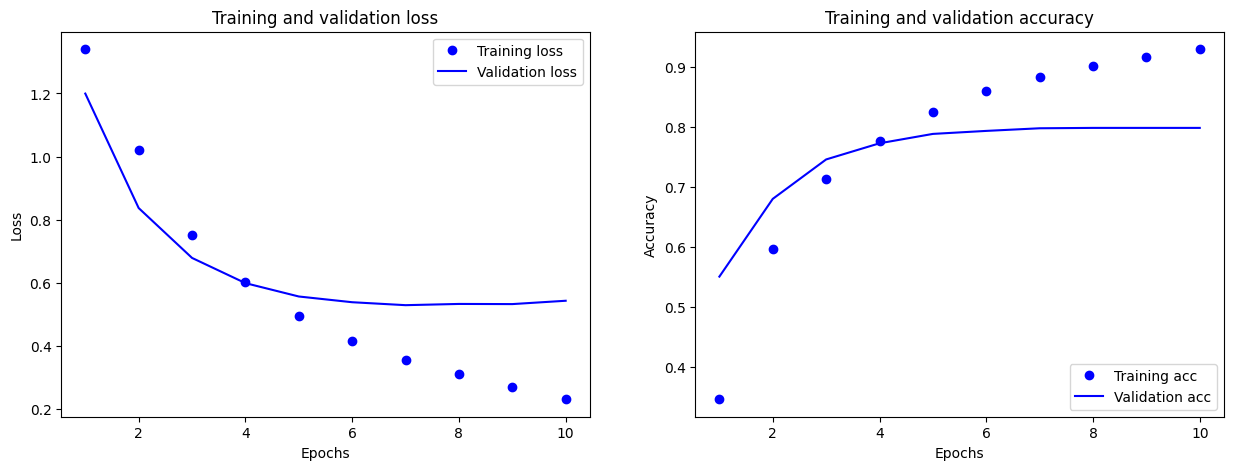

In [140]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(
    1, 2, figsize=(15, 5)
)

# "bo" is for "blue dot"
axs[0].plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')

plt.show()

As we can see, at around ~4 epochs we stopped getting as much benefit from training as our val-loss and val-accuracy stalled out with lower improvements. At around 6-7 epochs, our validation loss started going up again. So at around 6-7 epochs, we start to overfit.

# Exporting and testing our model

Lets try evaluate our model on raw test data.

In [141]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.6104 - accuracy: 0.7853
0.7852500081062317
